# Building Local Gaussian Process Surrogate Models from Scratch

In this notebook, we outline how to implement local Gaussian process (LGP) surrogate models for complex experimental observables from scratch. This code can be customized to any existing experimental data / training set. LGP surrogate models are a fast and accurate machine learning model that can approximate the outputs of an expensive function (e.g. a molecular simulation) with uncertainty quantification (UQ). UQ alleviates the 'black box' nature of machine learning and allows us to directly quantify parameter, model, and predictive uncertainties. This uncertainty naturally allows us to perform on-the-fly learning, model validation, and parameter sensitivity analysis.

The code provided below is designed to be a gentle introduction to LGP surrogate models with detailed instructions on how to implement LGP surrogates for any application. We will examine a LGP surrogate model of radial distribution functions in liquid Ne (described in the paper), but constructing your own surrogate model is as simple as uploading an experimental observable and molecular simulation training set and running them through our prebuilt functions.

In [1]:
# Required Math Packages
import numpy as np
import torch as torch
from scipy import interpolate
import emcee
from scipy.stats import gaussian_kde
from scipy.stats import lognorm, norm
import time

# Plotting Packages
import matplotlib.pyplot as plt  
from matplotlib.pyplot import figure
import corner

# data
import pickle
from pickle import dump, load

# Paralellization Packages and settings
from multiprocessing import Pool
import multiprocessing as mp
import os
mp.set_start_method('fork')
os.environ["OMP_NUM_THREADS"] = "1" 

# 1. Constructing a Training Dataset

The first step in building any supervised machine learning surrogate model is generating a training set. The training set represents "observations" from your model at many combinations of parameters. Ideally, the training set will span the parameter space of interest and be dense enough that the machine learning model can learn the patterns and relationships in the data to a high level of accuracy.  

For a single observable, $S(r_k)$, of data with many independent variables (spectra, scattering pattern, etc) the training set matrix for a local Gaussian process, $\mathbf{\hat{X'}}$, is an ($N$ $\times$ dim($\boldsymbol{\theta}$)) matrix, 

$$
    \mathbf{\hat{X'}} = 
        \begin{bmatrix}
        \theta_{1,1} & \theta_{2,1} & ...\\
        \theta_{1,2} & \theta_{2,2} & ...\\
        \vdots & \vdots & \vdots\\
        \theta_{1,N} & \theta_{2,N} & ...\\
        \end{bmatrix}
$$

where $\theta_{i,j}$ is the value of the $i^{th}$ model parameter $i = 1, ..., N_{params}$ for training sample $j = 1, ..., N$. This training set matrix is just row after row of training parameters appended together.

The training set observations, $\mathbf{\hat{Y'}}_k$, is a ($N$ $\times$ 1) column vector of the QOIs from the training set at $r_k$,

\begin{equation}
    \mathbf{\hat{Y}'}_k = [S(\boldsymbol{\theta}_1,r_k), ..., S(\boldsymbol{\theta}_N,r_k)]^T
\end{equation}

where the $k$ indexes over independent variables. Therefore, all we do is take the value of $r_k$ calculated from the training simulation and make a vector of these quantities in the same order as the training set data. 

Below, we ran 480 molecular simulations for a ($\lambda$-6) Mie fluid, which has three parameters: $\lambda$, the repulsive exponent that describes the deformability of a particle in a collision, $\sigma$ the effective collision diameter of the particle, and $\epsilon$ the dispersive attraction or "well-depth" of the potential. We used molecular dynamics (MD) to calculate a radial distribution function with 73 independent variables. For now, we choose a single independent variable to model,  which gives a training set matrix of size $(480 \times 3)$ and a training set observation vector with dimensions $(480 \times 73)$.

In [2]:
# Import the training data generated by 1_sample_gen.ipynb
rmin = 0.0118331810091873
rmax = 15.512161254882812
rnum = 73

k   = 3.29982916e-27 #boltzmann constant,   [kcal/K/particle]   
av  = 6.0223e23      #avagadro number,      [particle/mol]  
T   = 42.2           #temperature,          [K]
kbT = k * av * T

input_dict = load(open('training_data/samples.p', 'rb'))
xd = input_dict['xs']

input_dict = load(open('training_data/training_rdf.p', 'rb'))
r_raw = input_dict['r']
model_rdf_raw = input_dict['model_rdf']

model_rdf = torch.zeros(len(model_rdf_raw),rnum)
r = np.linspace(rmin,rmax,rnum)

# We can interpolate this data to have the same resolution as the experiment.
for i in range(len(model_rdf_raw)):
    rdf_i = interpolate.splrep(r_raw, model_rdf_raw[i], s=0)
    model_rdf[i] = torch.from_numpy(interpolate.splev(r, rdf_i, der=0))
    
print('Training Set Matrix Shape:       '      , np.shape(xd))            # total training set
print('Training Set Observations Shape: ', np.shape(np.array(model_rdf))) # array of independent observations 

Training Set Matrix Shape:        (480, 3)
Training Set Observations Shape:  (480, 73)


# 2. The Local Gaussian Process Surrogate Model

The time-complexity of the training-kernel matrix inversion and the matrix product can be substantially reduced by fragmenting a standard Gaussian process into a subset of Gaussian processes along the independent variables of the target quantity-of-interest (QOI). Under this construction, an individual $GP_k$ is trained to map a set of model parameters to an individual QOI,

\begin{equation}
    \mathbb{E}[GP_k] : \boldsymbol{\theta} \mapsto S(r_k)
\end{equation}

where $\mathbf{r}$ is no longer an input parameter. The LGP surrogate model prediction for the observable at $r_k$, $S_{loc}^*(r_k)$, at a new set of parameters, $\boldsymbol{\theta}^*$, is just the expectation of the $k^{th}$ Gaussian process given the training set data,

\begin{equation}\label{eq:subsurrogate}
    S_{loc}^*(r_k) = \mathbb{E}[\textit{GP}_k(\boldsymbol{\theta}^*)] = \mathbf{K}_{\boldsymbol{\theta}^*,\mathbf{\hat{X'}}} [\mathbf{K}_{\mathbf{\hat{X'}}, \mathbf{\hat{X'}}} + \sigma_{noise}^2 \mathbf{I}]^{-1} \mathbf{\hat{Y'}}_k
\end{equation}

In the following function, we take in variables created in the training set and the hyperparameters of the kernel to create a function that calculates this expectation. If we want to call the subset of Gaussian processes at every indpendent input with the same $\theta^*$ we can compute,

\begin{equation}
    [S_{loc}^*(r_1),...,S_{loc}^*(r_\eta)] = \mathbf{K}_{\boldsymbol{\theta}^*,\mathbf{\hat{X'}}} [\mathbf{K}_{\mathbf{\hat{X'}}, \mathbf{\hat{X'}}} + \sigma_{noise}^2 \mathbf{I}]^{-1} \mathbf{\hat{Y'}}
\end{equation}

### 2a. Including a GP Prior Mean

The previously described equation for the local Gaussian process surrogate model has mean 0. However, in some cases, it is useful to define an explicit prior mean function for the Gaussian process. This is particularly important for surrogate modeling complex data that is non-stationary, or in other words, has changing variances, covariances, and means as a function of its independent variables. Stochastic processes of this type are also referred to as heteroskedastic stochastic processes. Notably, a Gaussian process is a stationary model and therefore will perform poorly for non-stationary in general.

In the event that the data is non-stationary, a suitable mean function can be subtracted from the observable before attempting a local Gaussian process is applied to the data. The purpose of this is to make the observations stationary. In this way, $S_{loc}^*(\mathbf{r}|\boldsymbol{\theta}^*)$ becomes $y_{loc}^*(\mathbf{r}|\boldsymbol{\theta}^*) - \mathbf{\mu}_{LGP, k}^{prior}(\boldsymbol{\theta}^*,\mathbf{r})$ where the prior mean function is,

$$
    \mathbf{\mu}_{LGP, k}^{prior} := [\mu(\boldsymbol{\theta}_1,r_k), ..., \mu(\boldsymbol{\theta}_N,r_k)]^T
$$

such that $\mu(\boldsymbol{\theta}_j,r_k)$ is the GP prior mean for parameter $\boldsymbol{\theta}_j$ at $r_k$.
Note that the selection of a prior mean can impact the quality of fit of the GP surrogate model and should reflect physically justified prior knowledge of the physical system. In this case, we use the dilute limit potential of mean force (PMF) estimated radial distribution as the prior mean so that,

$$
    \mathbf{\mu}_{PMF, k}^{prior}(\boldsymbol{\theta}_j,r_k) := g(\boldsymbol{\theta}_j,r_k) = \exp{[-\beta V(\boldsymbol{\theta}_j,r_k)]}
$$

where $g(\boldsymbol{\theta}_j,r_k)$ and $V(\boldsymbol{\theta}_j,r_k)$ are the analytical dilute limit RDF and ($\lambda$-6) Mie potential for parameters $\boldsymbol{\theta}_j$ at $r_k$, respectively. A PMF prior mean yields physically realistic short-range ($g(r) = 0$) and long-range behavior ($g(r) \to 1$).

If you want to compare the use of different prior means, you can simply use the local_surrogate_ideal to learn a surrogate model with an ideal gas prior and local_surrogate_pmf to learn a surrogate model with the PMF prior. This code is set up to use the PMF prior, as we have found it gives more accurate surrogate models for RDFs. 

## 2b. Kernels

A kernel, or covariance function, completely specifies a Gaussian process prior. The kernel is highly specific to a given problem and therefore requires careful consideration before computing Gaussian process expectations. In general, the kernel can enforce function properties like continuity and differentiability, general behavior (periodicity, positivity), and symmetry. 

The kernel matrix, $\mathbf{K}$, quantifies the relatedness between input parameters and can be selected based on prior knowledge of the physical system. A standard kernel for physics-based applications is the squared-exponential (or radial basis function) since the resulting GP is infinitely differentiable, smooth, continuous, and has an analytical Fourier transform. The squared-exponential kernel function between input points $(\boldsymbol{\theta}_m,
r_m)$ and $(\boldsymbol{\theta}_n, r_n)$ is given by,

$$
    K_{mn} = \alpha^2 \exp\bigg(-\frac{(r_{m} - r_{n})^2}{2\ell_{r}^2} - \sum_{o=1}^{\text{dim}(\boldsymbol{\theta})}\frac{(\theta_{o,m} - \theta_{o,n})^2}{2\ell_{\theta_o}^2} \bigg)
$$

\noindent where $r$ indexes over the independent variables of the system, $o$ indexes over the model parameters of the system, and the hyperparameters $\alpha^2$ and $\ell_A$ are the kernel variance and correlation length scale of model parameter $A$, respectively. For a local Gaussian process, the independent variables are eliminated from the kernel matrix, giving a squared-exponential kernel of the form,


$$
    K_{mn} = \alpha^2 \exp\bigg( - \sum_{o=1}^{\text{dim}(\boldsymbol{\theta})}\frac{(\theta_{o,m} - \theta_{o,n})^2}{2\ell_{\theta_o}^2} \bigg)
$$

where $\sigma^2 \in \mathbb{R}$ is a scaling factor that represents the variance of the function and $\ell \in \mathbb{R}^{\text{dim}(\theta)}$ determines the length scale of fluctuations in the function. 

There are many resources available to choose the correct kernel for a given application. We recommend the Kernel Cookbook https://www.cs.toronto.edu/~duvenaud/cookbook/ or the textbook, Gaussian Processes by Rasmussen and Williams (2006). 

In [3]:
def se_kernel(x1, x2, l, width):
    """
    Computes the squared exponential kernel between the tensors x and y with hyper-parameters l and width.
    N corresponds to the number of samples and D corresponds to the number of dimensions of the input function.
    
    Parameters
    ----------
    x1: Tensor [N,D]
        Feature vector for N samples with D dimensions each
    
    x2: Tensor [N,D]
        Feature vector for N samples with D dimensions each
        
    l: Tensor [D]
        Lengthscale hyper parameter
        
    width: Float
        Width hyper parameter
        
    Returns
    ----------
    
    K: Tensor [N, N]
        Kernel matrix
        
    """
    K = width**2 * torch.exp(-(torch.cdist(x1/l,x2/l,p=2)**2)/2)
    return K

In [4]:
def local_surrogate_ideal(Xi, Xd, l, width, y, KddInv):
    """
    Computes the local gaussian process estimate of the structure factor given a set of pair potential parameters.
    This function assumes that the mean of y is equal to 1.  N corresponds to the number of training samples, 
    D corresponds to the number of dimensions of the input function, and M corresponds to the number of inference
    points.
    
    Parameters
    ----------
    
    Xi: Tensor [M,D]
        Feature vector for M samples with D dimensions each. This corresponds to the points you wish to infer.
    
    Xd: Tensor [N,D]
        Feature vector for N samples with D dimensions each. This corresponds to the points you trained on.
        
    l: Tensor [D]
        Lengthscale hyper parameter.
        
    width: Float
        Width hyper parameter
        
    KddInv: Tensor [N,N]
        This is the inverted kernel matrix of the training set Xd.
        
    Returns
    -------
    
    μ: Tensor [N,η]
        The mean estimate for the set of local GPs.
        
    """
    Kid = se_kernel(Xi, Xd, l, width)
    return 1 + ((Kid @ KddInv) @ (y-1)).T #by choosing a mean function of 1, we are assuming an ideal gas prior

def local_surrogate_pmf(Xi, Xd, l, width, y, KddInv, μd):
    """
    Computes the subset gaussian process estimate of the structure factor given a set of pair potential parameters. 
    
    Parameters
    ----------
    
    Xi: Tensor [M,D]
        Feature vector for M samples with D dimensions each. This corresponds to the points you wish to infer.
    
    Xd: Tensor [M,D]
        Feature vector for N samples with D dimensions each. This corresponds to the points you trained on.
        
    l: Tensor [D]
        Lengthscale hyper parameter.
        
    width: Float
        Width hyper parameter
        
    KddInv: Tensor [N,N]
        This is the inverted kernel matrix of the training set Xd
        
    Returns
    -------
    
    μ: Tensor [η,N]
        The mean estimate for each g(r) at each potential. The g(r)'s are organized in vertical lines where the column
        dimension indexes the potential parameters. 
        
    """
    #compute Mie potential at given conditions
    V = torch.stack([((n/(n-6))*((n/6)**((6)/(n-6))))*e*((s/r)**n - (s/r)**6) for n,s,e in zip(Xi[:,0],Xi[:,1],Xi[:,2])])
    #compute dilute limit PMF RDF
    μ = torch.exp(-V/kbT)
    Kid = se_kernel(Xi, Xd, l, width)
    
    #Subtract the prior mean from the input data, then add it back in at the end of regression
    return (μ +(Kid @ KddInv) @ (y-μd)).T

# 3. Bayesian Hyperparameter Optimization

Choosing hyperparameters for the local GP kernel is non-trivial and requires some additional considerations. In general, changing hyperparameters can change the expectation of the local GP, so it is desirable to choose a set of hyperparameters in a systematic way. Two common methods are to (1) maximize the log-marginal likelihood (model evidence) or (2) select a set of hyperparameters that minimize the leave-one-out (LOO) error. Here we implement Bayesian inference to compute the hyperposterior using a LOO based likelihood and take the maximum a posteriori (MAP) estimate.

Sometimes the Bayesian hyperposterior is not well-behaved, but we often find good hyperparameter approximations regardless. However, in the case that you want to propagate the hyperposterior uncertainty into the LGP, care must be taken to ensure that the hyperposterior is well-behaved and converged to obtain good results.

### CAUTION: Skip to Validation with a Test Set to Avoid Expensive Hyperparameter Optimization

If you are applying this to new data you will need to run the hyperparameter optimization code and delete the "training_data/map_hyperparams.p" file. However, we have hardcoded in results from this procedure in case you want to just run the model without performing hyperparameter optimization. 

## 3a. Bayesian Hyperprior, Likelihood, and Hyperposterior Functions

In [5]:
# Remake the Xd matrix for the subset matrix 
Xd = torch.tensor(xd).float()
y = model_rdf.float()

#define a positive definite matrix converter to improve numerical stability
@torch.no_grad()
def nearestPD(A):
      # Symmetrize A to ensure it's symmetric
      A_sym = (A + A.t()) / 2

      # Check for PD to see if thats all it took
      if torch.distributions.constraints._PositiveDefinite().check(A_sym):
          return A_sym
      
      # Perform eigenvalue decomposition
      eigenvalues, eigenvectors = torch.linalg.eigh(A_sym)
      
      # Reconstruct the matrix
      A_pos_def = (eigenvectors @ torch.diag(eigenvalues)) @ eigenvectors.t()
      condition = torch.distributions.constraints._PositiveDefinite().check(A_pos_def)
      mineigval = torch.min(eigenvalues)
      i = 0
      while not condition:
          A_pos_def = eigenvectors @ torch.diag(eigenvalues + 1/(2*10**(5-i)) - mineigval) @ eigenvectors.t()
          i += 1
          condition = torch.distributions.constraints._PositiveDefinite().check(A_pos_def)
      # print("Perturbed by:", 1/(2*10**(15-i-1)) - mineigval)
      return A_pos_def

In [6]:
# leave-one-out cross validation log marginal likelihood calculator assuming an ideal gas mean from Sundararajan (2001)
def g1(θ):
    l = torch.tensor([θ[0],θ[1],θ[2]]).float()
    w = torch.tensor(θ[3]).float()
    σn = torch.tensor(θ[4]).float()
    Kdd = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*(σn)
    KddInv = torch.linalg.inv(Kdd)
    KddInv_ii = torch.diagonal(KddInv, 0)
    logKddInv_ii = torch.log(KddInv_ii) 
    #assumes an ideal gas prior mean
    g = (1/(2*len(Xd)))*torch.sum(((KddInv @ (y - 1)).T/(torch.sqrt(KddInv_ii).repeat(rnum,1)))**2) - (rnum/(2*len(Xd)))*torch.sum(logKddInv_ii) + (rnum/2)*np.log(2*np.pi)
    return g

#LGP hyperpriors are normal but later exponentiated to ensure positive samples only
#rdf changes very slowly with changing n, we know from prior studies that its hard to distinguish rdfs with n +- 1.3 (exp(0.3))
μ_ℓ_n = 0.3
σ_ℓ_n = 2
prior_ℓ_n_dist = torch.distributions.normal.Normal(μ_ℓ_n, σ_ℓ_n)
def log_prior_ℓ_n(ℓ_n):
    return prior_ℓ_n_dist.log_prob(ℓ_n)

#rdf changes significantly for changing σ, expected variations occur over 0.05 Å (μ = exp(-3))
μ_ℓ_σ= -3
σ_ℓ_σ = 2
prior_ℓ_σ_dist = torch.distributions.normal.Normal(μ_ℓ_σ, σ_ℓ_σ)
def log_prior_ℓ_σ(ℓ_σ):
    return prior_ℓ_σ_dist.log_prob(ℓ_σ)

#expected variations of around 0.025 kcal/mol (μ = exp(-3.7))
μ_ℓ_ϵ= -3.7
σ_ℓ_ϵ = 2
prior_ℓ_ϵ_dist = torch.distributions.normal.Normal(μ_ℓ_ϵ, σ_ℓ_ϵ)
def log_prior_ℓ_ϵ(ℓ_ϵ):
    return prior_ℓ_ϵ_dist.log_prob(ℓ_ϵ)

# this should be a function of r, as the w parameter should be near 0 at low-r where there is no signal and positive elsewhere
μ_w = -2
σ_w = 2
prior_w_dist = torch.distributions.normal.Normal(μ_w, σ_w)
def log_prior_w(w):
    return prior_w_dist.log_prob(w)

# we expect the nuisance parameter to be quite small (on the order of noise in the rdf data ~ 0.03), but make prior wide to account for LGP uncertainty
μ_σn = -6
σ_σn = 3
prior_σn_dist = torch.distributions.normal.Normal(μ_σn, σ_σn)
def log_prior_σn(σn):
    return prior_σn_dist.log_prob(σn)

#Bayesian hyperposterior sampled by MCMC
def hyperpost(θ):
    try:
        θ = torch.tensor(θ)
        LH = -g1(θ.exp()) # log trick to ensure everything is positive, Sundararajan defines negative g in paper (must take negative here)
        if np.isnan(LH):
            return -np.inf
        return log_prior_ℓ_n(θ[0]) + log_prior_ℓ_σ(θ[1]) + log_prior_ℓ_ϵ(θ[2]) + log_prior_w(θ[3]) + log_prior_σn(θ[4]) +LH
    except:
        return -np.inf

## 3b. MCMC Sampling of the Hyperposterior

In [7]:
#NOTE: DO NOT RUN THIS UNLESS YOU NEED TO RETRAIN HYPERPARAMETERS AS IT TAKES A LONG TIME
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

try:
    print("Attempting to load previously calculated hyperparameters")    
    # Open the file in binary read mode and load the MAP estimate
    with open("training_data/map_hyperparams.p", "rb") as f:
        map_estimate = pickle.load(f)
    print("Loaded MAP estimate:", map_estimate)
    print("Success!!!")
    
except:
    # Create an initial position for the MCMC walkers
    ndim, nwalkers = 5, 22 # Make nwalkers = mp.cpu_count * 2 
    p0 = np.ones((nwalkers, ndim))

    cov = np.diag(np.array([σ_ℓ_n, σ_ℓ_σ, σ_ℓ_ϵ, σ_w, σ_σn]))/20
    
    # Set up the backend
    # Don't forget to clear it in case the file already exists
    filename = "training_data/MCMC_backend.h5"
    
    p0[:,0] = np.random.normal(μ_ℓ_n, σ_ℓ_n, nwalkers)
    p0[:,1] = np.random.normal(μ_ℓ_σ, σ_ℓ_σ, nwalkers)
    p0[:,2] = np.random.normal(μ_ℓ_ϵ, σ_ℓ_ϵ, nwalkers)
    p0[:,3] = np.random.normal(μ_w, σ_w, nwalkers)
    p0[:,4] = np.random.normal(μ_σn, σ_σn, nwalkers)
    
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)
    
    # Use pool to parallelize calculation
    print('Starting MCMC Run...')
    with Pool() as pool:
        #Create a sampler to run MCMC
        sampler = emcee.EnsembleSampler(nwalkers, ndim, hyperpost, backend = backend, pool = pool, moves=[emcee.moves.GaussianMove(cov)])
        max_n = 50000
        # We'll track how the average autocorrelation time estimate changes
        index = 0
        autocorr = np.empty(max_n)
        # This will be useful to testing convergence
        old_tau = np.inf
    
        # Now we'll sample for up to max_n steps
        for sample in sampler.sample(p0, iterations=max_n, progress=True, store=True, tune=True):
            # Only check convergence every 500 steps
            if sampler.iteration % 500:
                continue
    
            # Compute the autocorrelation time so far
            tau = sampler.get_autocorr_time(tol=0)
            autocorr[index] = np.mean(tau)
            index += 1
    
            # Check convergence
            converged = np.all(tau * 50 < sampler.iteration)
            converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
            if converged:
                break
            old_tau = tau

    filename = "training_data/MCMC_backend.h5"
    backend = emcee.backends.HDFBackend(filename)
    ndim, nwalkers = 5, 22 # Make nwalkers = mp.cpu_count * 2
    sampler = emcee.EnsembleSampler(nwalkers, ndim, hyperpost, backend = backend)
    print("Acceptance Fraction: ", np.mean(sampler.acceptance_fraction))
    tau = sampler.get_autocorr_time(tol=0)
    print("Autocorr = ", tau)
    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    
    # Flatten the chain after burn-in and thinning
    flat_samples = backend.get_chain(discard=burnin, flat=True, thin=thin)

    #Visualizing the Hyperposterior
    # Create the corner plot of your MCMC-sampled hyperposterior
    labels = [r"$\ell_{n}$", r"$\ell_{\sigma}$", r"$\ell_{\epsilon}$", r"$w$", r"$\sigma_n$"]
    fig = corner.corner(flat_samples, labels=labels,
                        show_titles=True, title_fmt=".2f", quantiles=[0.16, 0.5, 0.84], hist_kwargs = {"density": True})
    axes = np.array(fig.axes).reshape((5, 5))
    for i in range(5):
        ax = axes[i, i]
        # Get the current x-axis limits of the marginal histogram
        xlims = ax.get_xlim()
        x = np.linspace(xlims[0], xlims[1], 200)
        if i == 0:  
            s = σ_ℓ_n
            scale = μ_ℓ_n
        elif i == 1:  
            s = σ_ℓ_σ
            scale = μ_ℓ_σ
        elif i == 2:  
            s = σ_ℓ_ϵ
            scale = μ_ℓ_ϵ
        elif i == 3:  
            s = σ_w
            scale = μ_w
        elif i == 4:  
            s = σ_σn
            scale = μ_σn
        # Compute the lognormal pdf for these x values
        pdf = norm.pdf(x, loc=scale, scale=s)
        # Plot the prior pdf on the current diagonal axis.
        ax.plot(x, pdf, 'r', linestyle = '-', linewidth=2, label='Prior')
        ax.legend()
    plt.show()

    # Undo the log trick: exponentiate to get back to the original scale
    flat_samples = np.exp(flat_samples)
    
    # Use Gaussian KDE to estimate the density of the posterior and pickle
    kde = gaussian_kde(flat_samples.T)
    densities = kde(flat_samples.T)
    max_index = np.argmax(densities)
    map_estimate = flat_samples[max_index]
    print("MAP estimate:", map_estimate)
    with open("training_data/map_hyperparams.p", "wb") as f:
        pickle.dump(map_estimate, f)
    
    # Create the corner plot of your MCMC-sampled hyperposterior
    labels = [r"$\ell_{n}$", r"$\ell_{\sigma}$", r"$\ell_{\epsilon}$", r"$w$", r"$\sigma_n$"]
    fig = corner.corner(flat_samples, labels=labels,
                        show_titles=True, title_fmt=".2f", quantiles=[0.16, 0.5, 0.84], hist_kwargs = {"density": True})
    axes = np.array(fig.axes).reshape((5, 5))
    for i in range(5):
        ax = axes[i, i]
        # Get the current x-axis limits of the marginal histogram
        xlims = ax.get_xlim()
        x = np.linspace(xlims[0], xlims[1], 200)
        if i == 0:  
            s = σ_ℓ_n
            scale = μ_ℓ_n
        elif i == 1:  
            s = σ_ℓ_σ
            scale = μ_ℓ_σ
        elif i == 2:  
            s = σ_ℓ_ϵ
            scale = μ_ℓ_ϵ
        elif i == 3:  
            s = σ_w
            scale = μ_w
        elif i == 4:  
            s = σ_σn
            scale = μ_σn
        # Compute the lognormal pdf for these x values
        pdf = lognorm.pdf(x, s=s, scale=np.exp(scale))
        # Plot the prior pdf on the current diagonal axis.
        ax.plot(x, pdf, 'r', linestyle = '-', linewidth=2, label='Prior')
        ax.legend()
    plt.show()

Attempting to load previously calculated hyperparameters
Loaded MAP estimate: [1.23515899e+01 1.61397989e-01 3.49269301e-02 1.20214806e+00
 1.90129604e-04]
Success!!!


# 4. Validation

Now that you have specified the local Gaussian process surrogate model and found appropriate hyperparameters, you can check whether or not the surrogate model is working properly by comparing its prediction to an external test set. We evaluate the model accuracy by computing the root-mean-squared-error (RMSE) between a test set of simulation data and the LGP surrogate model. 

In [8]:
#load in training set data
input_dict = load(open('testing_data/test_data.p', 'rb'))
totalResults = input_dict['totalResults']
totalTime = input_dict['totalTime']

# Reload Samples
input_dict = load(open('testing_data/test_samples.p', 'rb'))
xs_MAPTest = input_dict['xs']
nsampsTest = len(xs_MAPTest[:,0])
ndimsTest  = len(xs_MAPTest[0,:])

In [9]:
# Define training set data|
Xd = torch.tensor(xd).float()
y = model_rdf.float()

# pmf prior mean
Vd = torch.stack([((n/(n-6))*((n/6)**((6)/(n-6))))*e*((s/r)**n - (s/r)**6) for n,s,e in zip(Xd[:,0],Xd[:,1],Xd[:,2])])
μd = torch.exp(-Vd/kbT).float() #PMF prior mean

# Choose hyperparameters
# arr = [1.04676681e+01, 1.51963546e-01, 3.72454361e-02, 1.07951835e+00, 1.75394610e-04]   # hardcoded in hyperparameters
arr = map_estimate       
l = torch.tensor([arr[0],arr[1],arr[2]]).float()
w = torch.tensor(arr[3]).float()
σn = torch.tensor(arr[4]).float()

# Compute local GP prediction over prior predictive set
Kdd = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*(σn)
Kdd_pd = nearestPD(Kdd)
L = torch.linalg.cholesky(Kdd_pd)
KddInv = torch.cholesky_inverse(L)

Xi = torch.tensor(xs_MAPTest).float()
GPOut = local_surrogate_ideal(Xi, Xd, l, w, y, KddInv)

err = torch.zeros(160)    #number of test set simulations
for i in range(160):
    err[i] = torch.sqrt(torch.sum((GPOut.T[i] - totalResults[i])**2)/73)

RMSE = torch.sqrt(torch.mean((GPOut.T - totalResults)**2,dim=0))
RMSE_total = torch.sqrt(torch.mean((GPOut.T - totalResults)**2))
print("RMSE Over Test Set:",float(RMSE_total))

RMSE Over Test Set: 0.012182853184640408


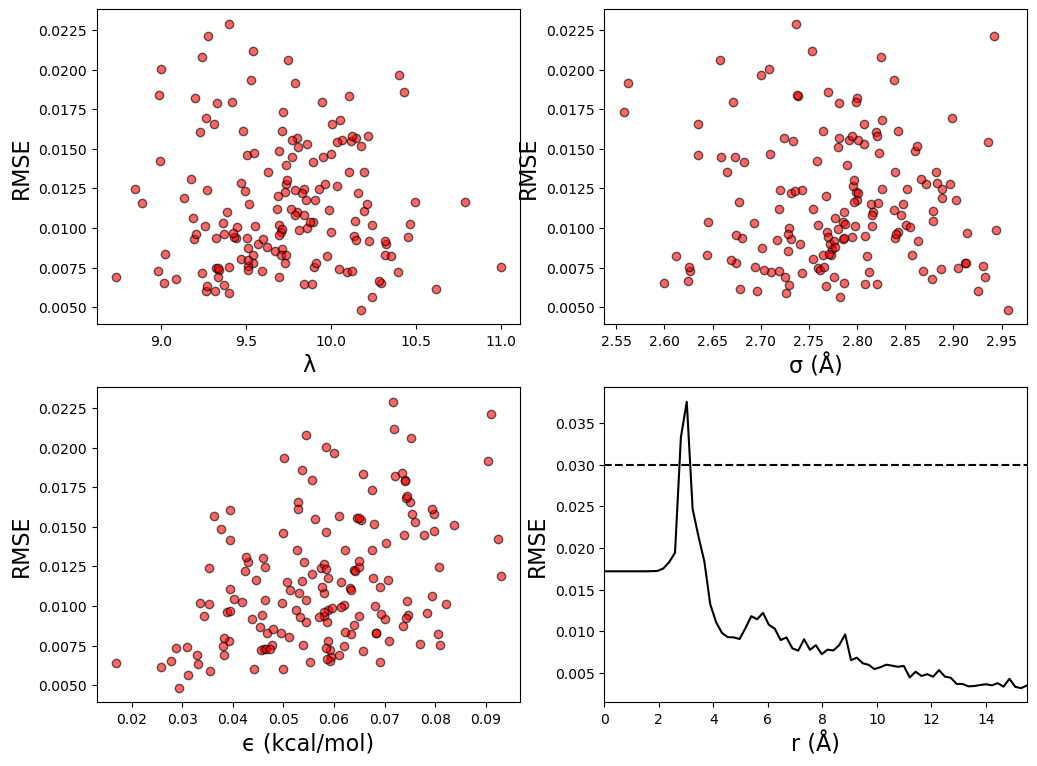

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
axs[0,0].scatter(xs_MAPTest[:,0], err, color = 'r', alpha = 0.6, edgecolors = 'k')
axs[0,0].set_xlabel('λ', fontsize = 16)
axs[0,0].set_ylabel('RMSE', fontsize = 16)
axs[0,1].scatter(xs_MAPTest[:,1], err, color = 'r', alpha = 0.6, edgecolors = 'k')
axs[0,1].set_xlabel('σ (Å)', fontsize = 16)
axs[0,1].set_ylabel('RMSE', fontsize = 16)
axs[1,0].scatter(xs_MAPTest[:,2], err, color = 'r', alpha = 0.6, edgecolors = 'k')
axs[1,0].set_xlabel('ϵ (kcal/mol)', fontsize = 16)
axs[1,0].set_ylabel('RMSE', fontsize = 16)
axs[1,1].axhline(0.03, color = 'k', linestyle = '--')
axs[1,1].plot(r,RMSE, color = 'k', label = 'Mean', linestyle = '-')
axs[1,1].set_xlim(0, r[-1])
axs[1,1].set_xlabel('r (Å)', fontsize = 16)
axs[1,1].set_ylabel('RMSE', fontsize = 16)
plt.show()

# 5. Concluding Remarks

Local Gaussian processes are fast and accurate surrogate models for molecular simulation applications that are especially suited for experimental data with many independent variables, such as scattering patterns or electromagnetic spectra. The methods outlined in this notebook are transferable to any data type and molecular simulation method, all that you need to do is replace the training set, test set, and experimental data with the equivalent matrices specified by your own problem. As long as these matrices are specified correctly, this notebook should be sufficient to construct an LGP surrogate model for any application in physical chemistry. 